In [1]:
%load_ext autoreload
%autoreload 2

Hereafer I will import some of the python libraries I will use in the solution:

In [2]:
import numpy as np
import pandas as pd
import logging
import os, sys
import yaml
from sklearn.model_selection import train_test_split
import logging
from functools import partial

I am defining the logger, I will use it to print some information about the execution:

In [3]:
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%d/%m/%Y %I:%M:%S%p")

logger = logging.getLogger(__name__)

# Example: Italy's quarterly GDP forecast

In this notebook we will build a model to forecast the quarterly GDP of Italy.

In [4]:
from source.feature_extractor import FeatureExtraxtor
from source.model import MLmodel

I am loading the dataset from the web:

In [5]:
worldbank_data = pd.read_csv(os.path.join('data', 'WB_DATA_d950d0cd269a601150c0afd03b234ee2.csv'))
global_economic_indicators = pd.read_csv(os.path.join('data', 'EDIA_ECD_2_8e348bab98f433be151f325a46767c38.csv'))

Getting the target variable:

In [6]:
target_variable = global_economic_indicators.loc[(global_economic_indicators.country_code == 'IT') & 
                                                 (global_economic_indicators.series_id == 54372)].set_index('date')['value'].shift(-1).dropna()
target_variable

date
1996-01-01    324952.1
1996-04-01    317006.3
1996-07-01    333546.7
1996-10-01    307808.1
1997-01-01    331192.8
                ...   
2018-01-01    370569.9
2018-04-01    364906.0
2018-07-01    372207.3
2018-10-01    354904.5
2019-01-01    369908.6
Name: value, Length: 93, dtype: float64

Getting some features:

In [7]:
italy_all_quarterly_data = global_economic_indicators.loc[(global_economic_indicators.frequency == 'Q') & 
                                                (global_economic_indicators.country_code == 'IT')]


In [8]:
dataset = target_variable.reset_index().rename(columns={'value' : 'target_variable'})

for data in italy_all_quarterly_data.description.unique():
    print(f"Merging {data}")
    quarterly_feature =  italy_all_quarterly_data.loc[italy_all_quarterly_data.description == data][['date','value']].rename(columns={'value' : data})
    dataset = pd.merge(dataset, quarterly_feature, on='date', how='left')

Merging Italy: Private Consumption Growth (%) [IT: GDP: Final Domestic Consumption (FDC):: PCTCHG]
Merging Italy: Gross Fixed Investment Growth (%) [IT: GFCF: Total Fixed Assets by Type of Asset (TFATA): PCTCHG]
Merging Italy: Government Consumption Growth (%) [Italy: GDP: (sa): Current prices: Government final consumption: PCTCHG]
Merging Italy: Real GDP Growth (%) [IT: Gross Value Added (GVA): At Basic Prices (BP): 2010p: PCTCHG]
Merging Italy: GDP Deflator (Y=Y) [Italy: GDP Deflator]
Merging Italy: Nominal GDP ($B) [IT: Gross Value Added (GVA): At Basic Prices (BP)]
Merging Italy: Real Gross Fixed Investment ($B) [Italy: GDP: (sa): Constant prices: Gross fixed capital formation]
Merging Italy: Real GDP ($B) [IT: Gross Value Added (GVA): At Basic Prices (BP): 2010p]
Merging Italy: Industrial Production Growth (%) [IT: Industrial Production Index (IPI-15): PCTCHG: QUARTERLYN]
Merging Italy: Budget Expenditure / GDP (%) [Italy: General Govt: Operations Stmt: Expense [2]: * 100 /023_Q>>

## Model

In this section I will define and train the model.

I am defining X and y:

In [9]:
X = dataset.drop(columns='target_variable').set_index('date').fillna(-999)
y = dataset.set_index('date')['target_variable']

I am splitting both the features and the ground truth into a train and test sample:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False)

For this exercise, I've tested several tree-based model. I defined them in a configuration file called model_settings.yaml, now I am importing that in the code:

In [11]:
with open(os.path.join('source', 'model_settings.yaml'), 'r', encoding="utf-8") as handler:
    model_params = yaml.load(handler, Loader=yaml.FullLoader)

Now I am defining an instance of a MLmodel object, a class defined in the model.py module (in the source folder) that contain several useful methods for dealing with tree based classification models.
I've choosen this class of models because they offer a great compromise between simplicity and quality of the predictios.

In [12]:
regressor = MLmodel(model_params['RandomForest'])

Now I am launching the optimization routine based on gridsearch or randomsearch (to be chosen in the configuration file). 

In [13]:
# TODO -> The optimization routine must be fixed
# regressor.optimize(X_train, y_train)

Finally, I am fitting the model:

In [14]:
regressor.fit(X_train, y_train)

## Feature Importance

Now I am assembling the predictions:

In [15]:
results_train = y_train.reset_index()
results_test = y_test.reset_index()
results_train['Prediction'] = regressor.predict(X_train)
results_test['Prediction'] = regressor.predict(X_test)

In the cell below, I'll print some quality metrics, to check the quality of the model:

In [16]:
#TODO 

Let's plot the features importances. Tree based models offer a simple method to check the relative importances of the features, so I think they are a great choice to easily get some extra-insight about the goodness of the chosen features. In this case, I made several attempts and I deleted some features which importance were always 0 or close to 0. There are also automatic routines defined in scikit-learn to do this task (for example sklearn.feature_selection.RFE) but they require a lot of time to run.

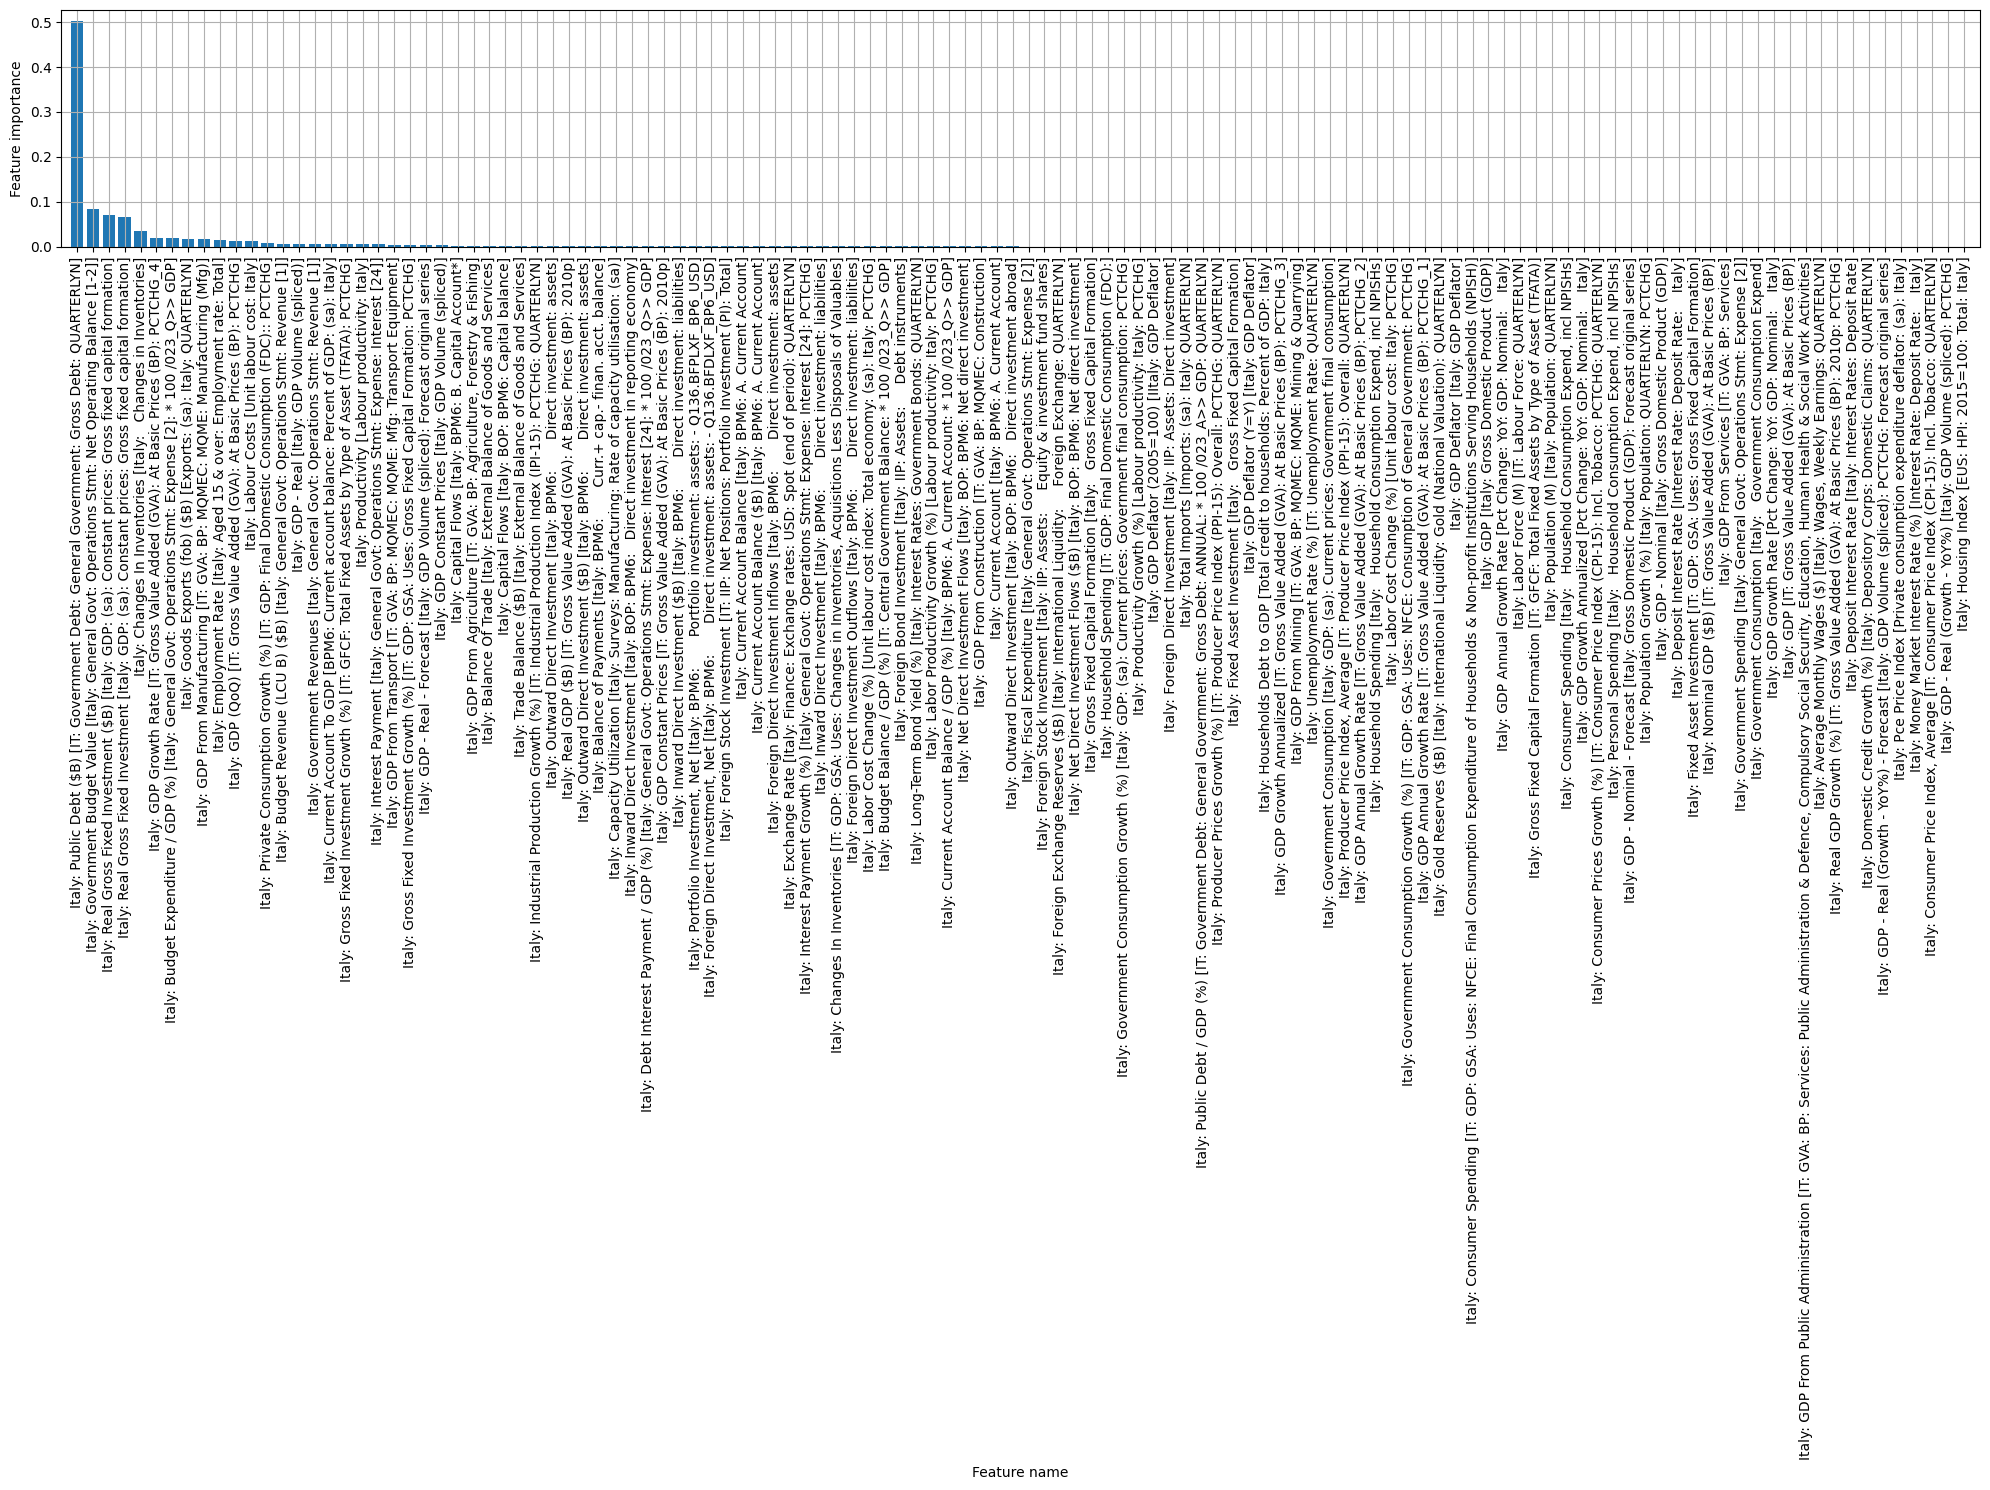

26/05/2024 10:17:19AM - INFO - 
--------- Feature Importance ---------
26/05/2024 10:17:19AM - INFO -  1) Italy: Public Debt ($B) [IT: Government Debt: General Government: Gross Debt: QUARTERLYN] 0.502006
26/05/2024 10:17:19AM - INFO -  2) Italy: Government Budget Value [Italy: General Govt: Operations Stmt: Net Operating Balance [1-2]] 0.084237
26/05/2024 10:17:19AM - INFO -  3) Italy: Real Gross Fixed Investment ($B) [Italy: GDP: (sa): Constant prices: Gross fixed capital formation] 0.069771
26/05/2024 10:17:19AM - INFO -  4) Italy: Real Gross Fixed Investment [Italy: GDP: (sa): Constant prices: Gross fixed capital formation] 0.067035
26/05/2024 10:17:19AM - INFO -  5) Italy: Changes In Inventories [Italy:   Changes in Inventories] 0.034435
26/05/2024 10:17:19AM - INFO -  6) Italy: GDP Growth Rate [IT: Gross Value Added (GVA): At Basic Prices (BP): PCTCHG_4] 0.018853
26/05/2024 10:17:19AM - INFO -  7) Italy: Budget Expenditure / GDP (%) [Italy: General Govt: Operations Stmt: Expense 

In [17]:
regressor.plot_features_importances(X.columns)

# PredictionPlot

In [23]:
full_hist = pd.concat([results_train, results_test])
full_hist

,date,target_variable,Prediction
0,1996-01-01,324952.1,324952.100
1,1996-01-01,324952.1,324952.100
2,1996-01-01,324952.1,324952.100
3,1996-01-01,324952.1,324952.100
4,1996-01-01,324952.1,324952.100
...,...,...,...
144,2019-01-01,369908.6,363161.672
145,2019-01-01,369908.6,363161.672
146,2019-01-01,369908.6,363161.672
147,2019-01-01,369908.6,363161.672


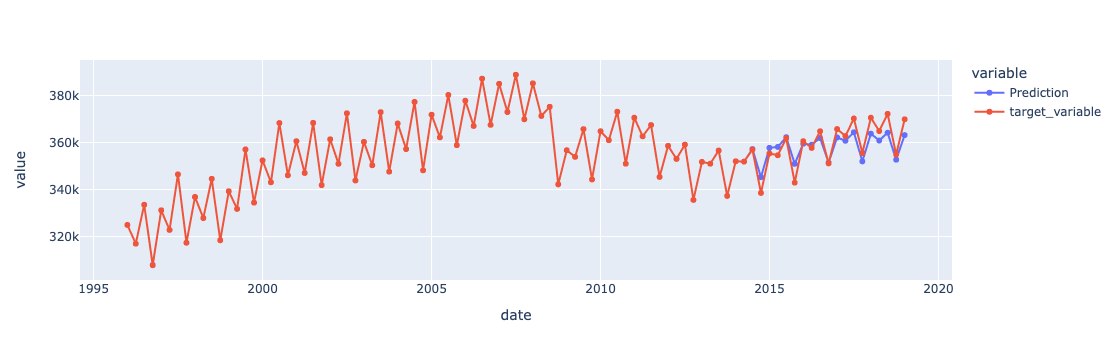

In [26]:
import plotly.express as px
fig = px.line(full_hist, x='date', y=['Prediction', 'target_variable'], markers=True)
fig.show()